## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [167]:
# All imports in one place
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random
from keras.regularizers import l2, activity_l2
import pandas
import os
import matplotlib.image as mpimg
import tensorflow as tf
import matplotlib.gridspec as gridspec

In [19]:
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# combine the training and validation together, we will take out a part of the total for validation later, regardless
X_train = np.concatenate((train['features'], valid['features']))
y_train = np.concatenate((train['labels'], valid['labels']))

# extract the test data
X_test, y_test = test['features'], test['labels']

In [20]:
# Separate out validation data out of the training data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(27446, 32, 32, 3) (27446,)
(11763, 32, 32, 3) (11763,)


In [108]:
signNames = pandas.read_csv('./signnames.csv')

def getSignNameFromIndex(index, labels):
    return signNames[signNames['ClassId'] == labels[index]]['SignName'].values[0]

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

In [21]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
print(X_train.shape)
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of classes =", n_classes)

(27446, 32, 32, 3)
Number of training examples = 27446
Number of testing examples = 12630
Number of classes = 43


### Pre-process and visualize the Data Set

First we want to shuffle the data to ensure random ordering.

In [22]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train) 

Let's visualize some of the raw dataset.

In [104]:
def plot100RandomImages(images, cmap = None):
    plot100Images(shuffle(images), cmap)
    
def plot100Images(images, cmap = None):
    fig = plt.figure(1, (16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for i in range(100):
        image = images[i]
        grid[i].imshow(image, cmap=cmap)  # The AxesGrid object work as a list of axes.

    plt.show()

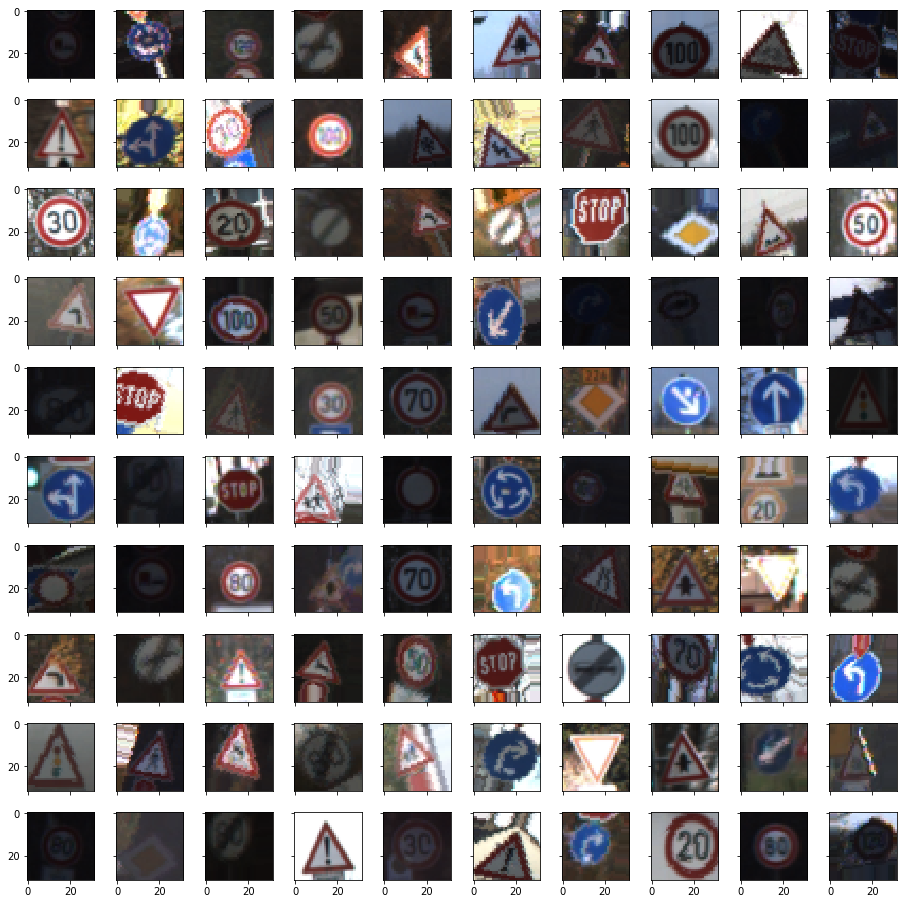

In [103]:
plot100RandomImages(X_train)

Next, we should try to visualize the distribution of different classes inside of our data set.

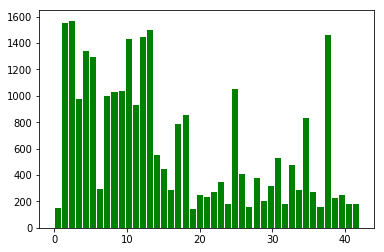

In [24]:
_,_,_ = plt.hist(y_train, bins=43, facecolor='green', rwidth=0.85)
plt.show()

The dataset seems pretty unbalanced. This causes the network to train better on the frequent traffic signs, and undertrain for the classes that are under-represented. After a couple of trial runs, I plotted the histogram for the traffic signs that were misclassified, and it pretty much was the opposite of this one => network was most often misclassifying signs that we had less of in the training dataset.

The first thing to try would be to generate additional data for all images. This way, the ratio of the classes will be kept while providing more data for the network to learn better the currently under-represented signs.

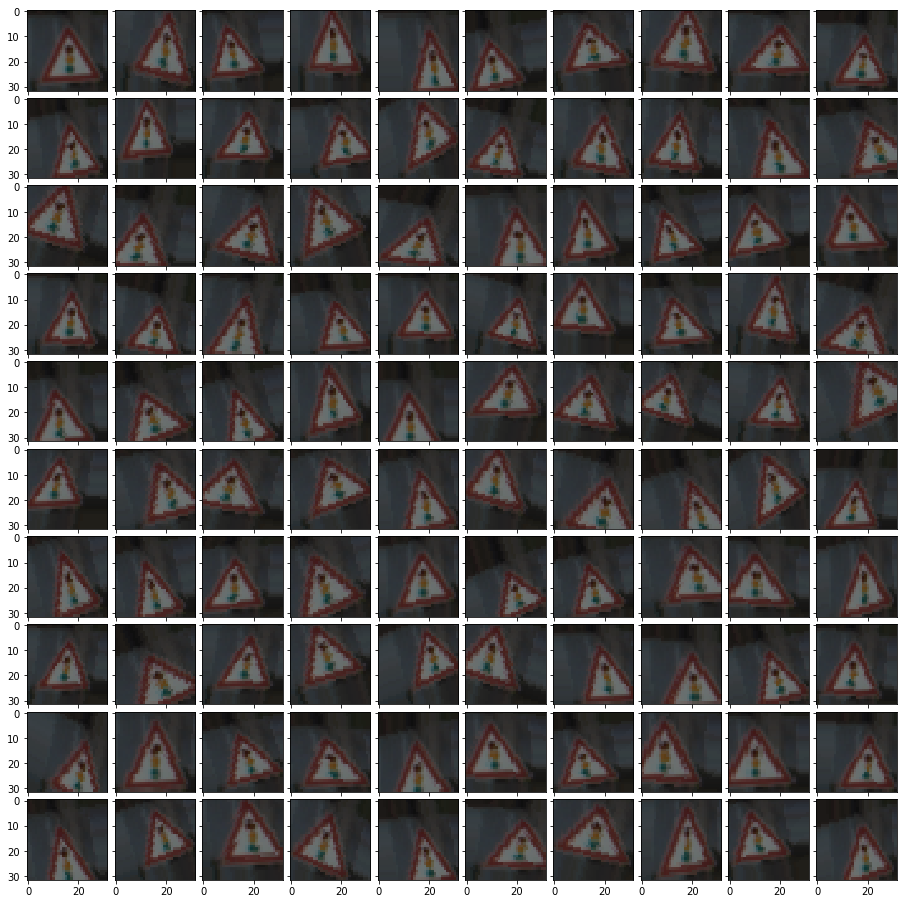

In [25]:
def generate_image(img):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')
    
    generator = datagen.flow(img.reshape((1,) + img.shape), batch_size = 1)
    new_img = generator.next()
    return new_img.reshape(new_img.shape[1:]).astype(np.uint8)
    
index = random.randint(0, len(X_train))
x = X_train[index]

images = []
images.append(x)

for i in range(99):
    images.append(generate_image(x))

plot100Images(images)

In [26]:
def balanceDataSet(data, labels, desired_count):
    _, unique = np.unique(labels, return_counts=True)
    for label, curr_count in enumerate(unique):
        new_data_count =  desired_count - curr_count
    
        input_data, input_labels = resample(data[labels == label], labels[labels == label], n_samples=new_data_count, random_state=42)

        generated_data = []
        # apply transform on each image
        for image in input_data:
            generated_data.append(generate_image(image))
        
        data = np.concatenate((data, generated_data))
        labels = np.concatenate((labels, input_labels))
    return data, labels

X_train, y_train = balanceDataSet(X_train, y_train, 2500)

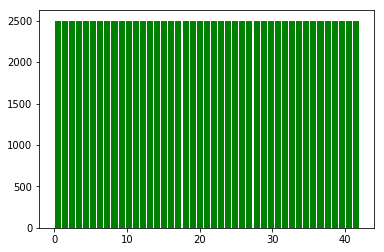

In [27]:
_,_,_ = plt.hist(y_train, bins=43, facecolor='green', rwidth=0.85)
plt.show()

Next, let's convert the images into grayscale.

In [28]:
X_train_grayscale = np.dot(X_train[...,:3], [0.299, 0.587, 0.114])
X_valid_grayscale = np.dot(X_valid[...,:3], [0.299, 0.587, 0.114])
X_test_grayscale = np.dot(X_test[...,:3], [0.299, 0.587, 0.114])

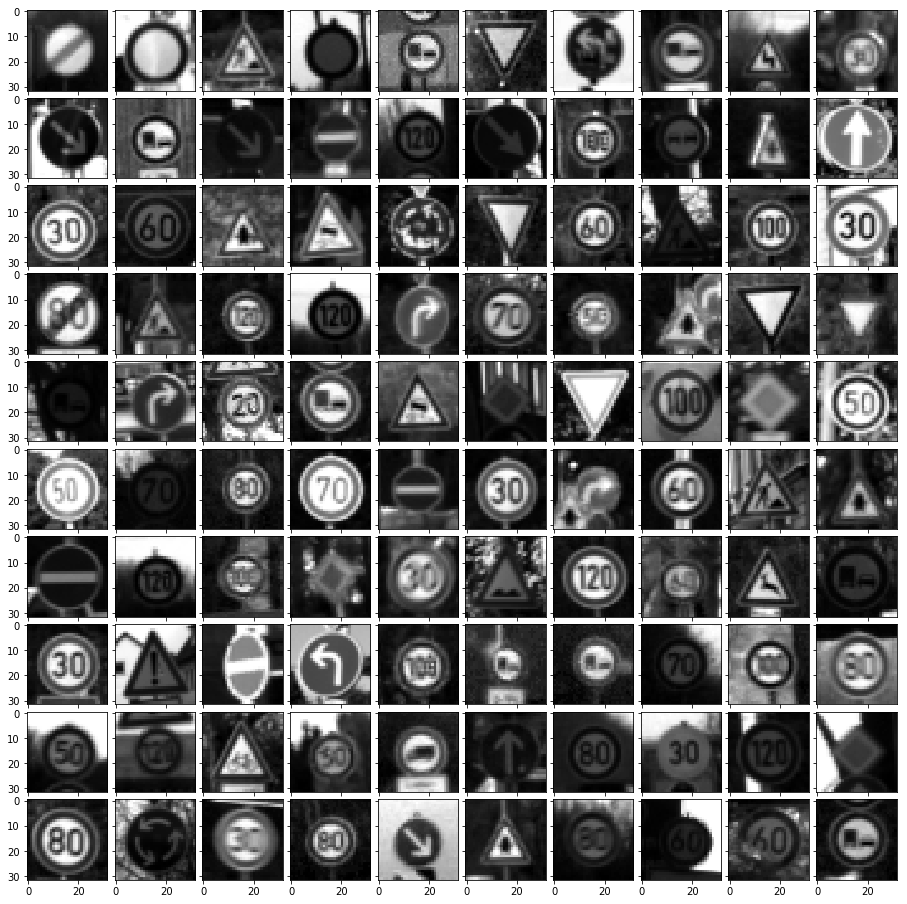

In [29]:
plot100Images(X_train_grayscale, cmap = 'gray')

In [ ]:
# Normalize the data features to the variable X_normalized
from skimage import exposure

def normalize_grayscale(X):
    X = (X/255.).astype(np.float32)

    for i in range(X.shape[0]):
        X[i] = exposure.equalize_adapthist(X[i])
    
    X = -0.5 + X
    return X

X_train_normalized = normalize_grayscale(X_train_grayscale)
X_valid_normalized = normalize_grayscale(X_valid_grayscale)
X_test_normalized = normalize_grayscale(X_test_grayscale)

In [185]:
pickle.dump({'features': X_train_normalized, 'labels':y_train}, open('train_normalized.p', 'wb'))
pickle.dump({'features': X_valid_normalized, 'labels':y_valid}, open('valid_normalized.p', 'wb'))
pickle.dump({'features': X_test_normalized, 'labels': y_test}, open('test_normalized.p', 'wb'))

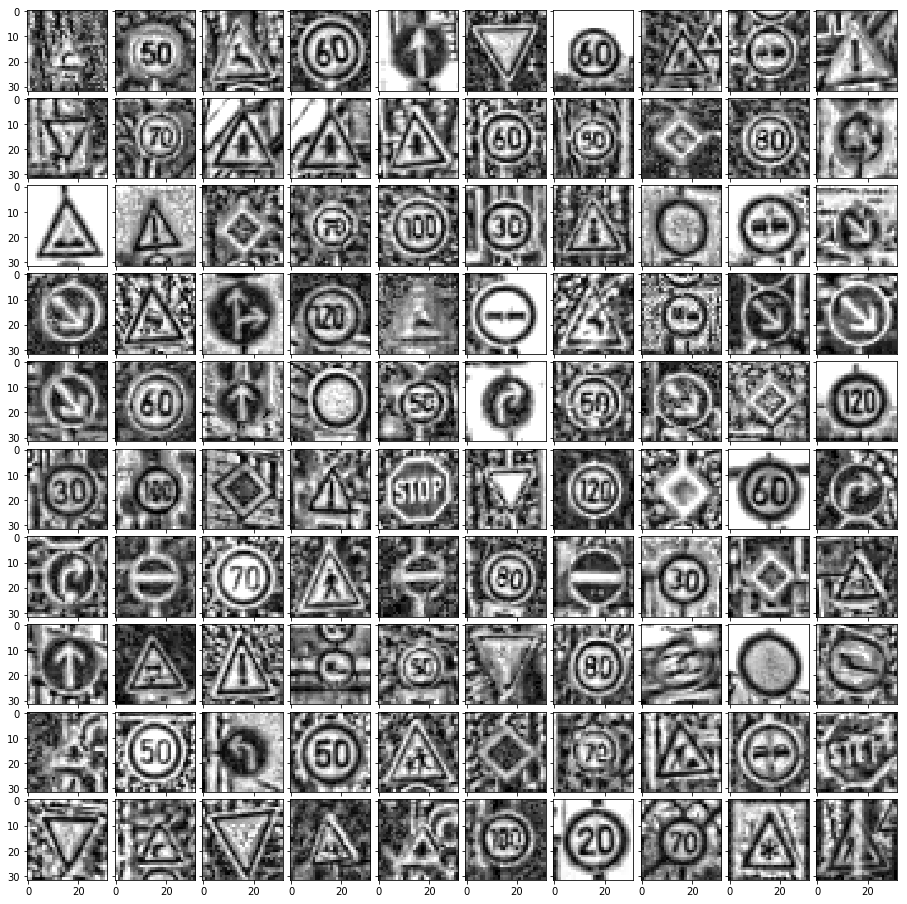

In [32]:
plot100Images(X_train_normalized, cmap = 'gray')

In [33]:
X_train_normalized = X_train_normalized.reshape((X_train_normalized.shape[0], 32, 32, 1))
X_valid_normalized = X_valid_normalized.reshape((X_valid_normalized.shape[0], 32, 32, 1))
X_test_normalized = X_test_normalized.reshape((X_test_normalized.shape[0], 32, 32, 1))

In [34]:
image_shape = X_train_normalized.shape[1:]
print("Image shape: ", image_shape)

Image shape:  (32, 32, 1)


### Model Architecture

In [35]:
model = Sequential()
model.add(Convolution2D(32, 5, 5, input_shape = image_shape,  W_regularizer=l2(0.00001)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 5, 5,  W_regularizer=l2(0.00001)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024,  W_regularizer=l2(0.00001)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024,  W_regularizer=l2(0.00001)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(n_classes,  W_regularizer=l2(0.00001)))
model.add(Activation('softmax'))

### Save and load models

In [36]:
def save(model, fname):
    # serialize model to JSON
    model_json = model.to_json()
    with open(fname + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(fname + '.h5')
    print("Saved model to disk")

In [37]:
from keras.models import model_from_json
def load(fname):
    # load json and create model
    json_file = open(fname + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(fname + '.h5')
    print("Loaded model from disk")
    return loaded_model

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [38]:
# one hot econding
label_binarizer = LabelBinarizer()
y_train_one_hot = label_binarizer.fit_transform(y_train)
y_valid_one_hot = label_binarizer.fit_transform(y_valid)

In [82]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
import keras
adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy', ['accuracy'])
history = model.fit(X_train_normalized, y_train_one_hot, batch_size=128, nb_epoch=10, validation_data=(X_valid_normalized, y_valid_one_hot))

Train on 107500 samples, validate on 11763 samples
Epoch 1/10
107500/107500 [==============================] - 14s - loss: 0.3435 - acc: 0.9270 - val_loss: 0.1305 - val_acc: 0.9976

In [179]:
scores = model.evaluate(X_train_normalized, y_train_one_hot, verbose=0)
print("Training set %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

scores = model.evaluate(X_valid_normalized, y_valid_one_hot, verbose=0)
print("Validation set %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Training set acc: 99.66%
Validation set acc: 99.76%


In [181]:
prediction = model.predict(X_train_normalized)

In [182]:
bin_pred = (prediction == prediction.max(axis=1, keepdims=True)).astype(int)
wrong = []
right = []
images = []
for i in range(bin_pred.shape[0]):
    pred = np.where(bin_pred[i] == 1)[0][0]
    actual = np.where(y_train_one_hot[i] == 1)[0][0]
    if pred != actual:
        wrong.append(actual)
        images.append(X_train_normalized[i].reshape((32, 32)))
    else:
        right.append(actual)

4250


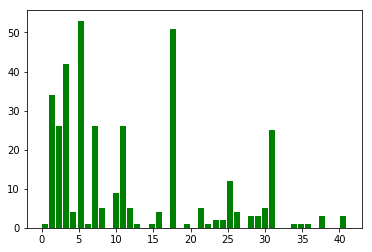

In [183]:
print(sum(wrong))
_,_,_ = plt.hist(wrong, bins=43, facecolor='green', rwidth=0.85)
plt.show()

2253250


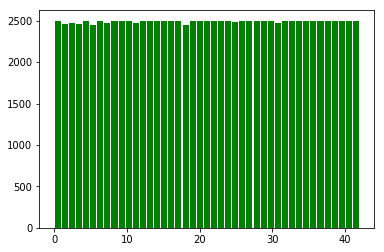

In [184]:
print(sum(right))
_,_,_ = plt.hist(right, bins=43, facecolor='green', rwidth=0.85)
plt.show()

In [80]:
save(model, "TrafficSign-3-9976-valid")

Saved model to disk


In [178]:
loaded_model = load("TrafficSign-3-9976-valid")
loaded_model.compile('adam', 'categorical_crossentropy', ['accuracy'])
scores = loaded_model.evaluate(X_test_normalized, y_test_one_hot, verbose=0)
print("Test data %s: %.2f%%" % (loaded_model.metrics_names[1], scores[1]*100))

Loaded model from disk
Test data acc: 97.89%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

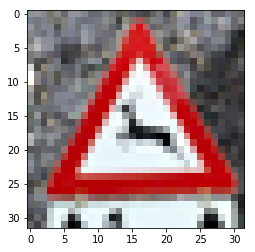

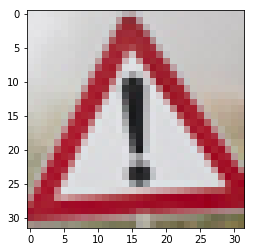

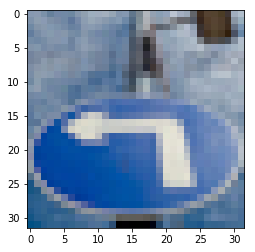

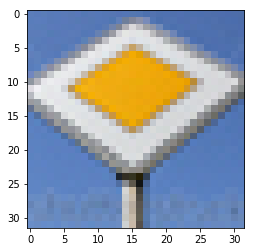

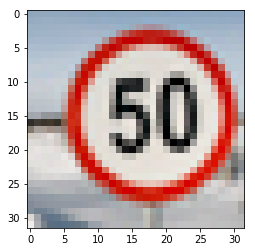

In [176]:
new_test_image_names = os.listdir("test_images/")
new_test_images = np.asarray([np.copy(mpimg.imread("test_images/" + image_name)) for image_name in new_test_image_names])

for img in new_test_images:
    plt.imshow(img)  # The AxesGrid object work as a list of axes.
    plt.show()

### Predict the Sign Type for Each Image

In [143]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
new_test_images = np.dot(all_images[...,:3], [0.299, 0.587, 0.114])
new_test_images = normalize_grayscale(new_test_images)
new_test_images = new_test_images.reshape((new_test_images.shape[0], 32, 32, 1))

0


/home/jocko/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


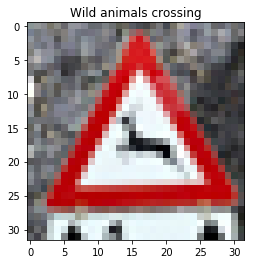

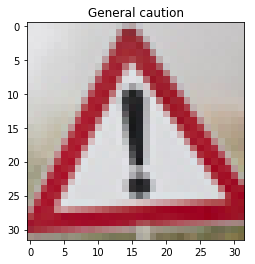

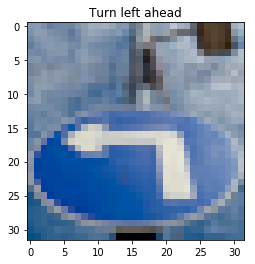

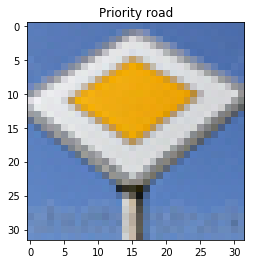

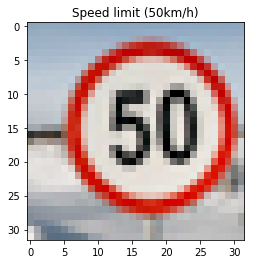

In [153]:
new_prediction = model.predict(new_test_images)
new_bin_pred = (new_prediction == new_prediction.max(axis=1, keepdims=True)).astype(int)
new_label_prediction = [np.where(pred == 1)[0][0] for pred in new_bin_pred]
for i in range(len(all_images)):
    plt.imshow(all_images[i])  # The AxesGrid object work as a list of axes.
    plt.title(getSignNameFromIndex(i, new_label_prediction))
    plt.show()

### Analyze Performance

Looks great! The model correctly classified all 5 images!

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [161]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(tf.constant(new_prediction), k=5))
    top5_values = top5.values
    top5_indices = top5.indices

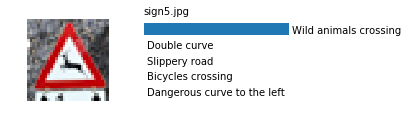

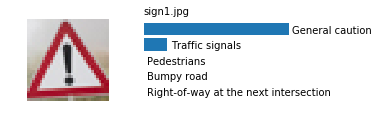

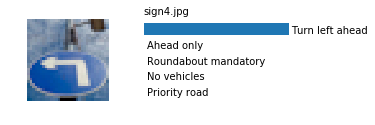

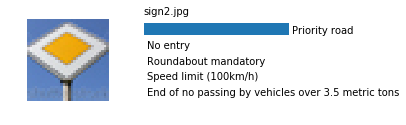

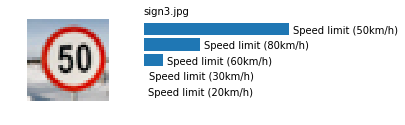

In [177]:
# the nice probability visualization below is a modified version of the code found at
# https://github.com/hello2all/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier.ipynb
# Thanks for not having to do it myself! :)
for i in range(5):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(new_test_images[i])
    plt.axis('off')
    plt.subplot(gs[1])
    plt.barh(6-np.arange(5),top5_values[i], align='center')
    for i_label in range(5):
        plt.text(top5_values[i][i_label]+.02,6-i_label-.25, getSignNameFromIndex(i_label, top5_indices[i]))
    plt.axis('off')
    plt.text(0,6.95, new_test_image_names[i])
    plt.show()